# A simple keras implementation of CBRAIN

The creation of the data sets is done in the data_conversion notebook.

In [52]:
# Imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc

In [53]:
# Some basic setup
np.random.seed(42)
sns.set_style('white')

# Directory where netCDF files are stored
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sample/'   # 100,000 samples

In [69]:
# Features and targets from Pierre's submit script
# Make it a dictionary with 
# Get variable meaning from ??? Need to look that up at some point!
feature_vars = {
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'OMEGA': 2,           # [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'LAT': 1,             # Latitude [sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'QRL': 2,             # Long wave heating rate [z, sample]
    'QRS': 2,             # Short wave heating rate [z, sample]
}
target_dics = {
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
}

## Visualize task of the network

The goal of this section is to get an intuition of the task at hand. What are the inputs, what are the outputs? How does this depend on latitude?

In [24]:
# Load the training set
train_out = nc.Dataset(data_dir + 'SPCAM_outputs_train.nc')
train_out

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(21), t(80000)
    variables(dimensions): float64 LAT(t), float64 PS(t), float64 SHFLX(t), float64 LHFLX(t), float64 OMEGA(z,t), float64 QAP(z,t), float64 TAP(z,t), float64 QRL(z,t), float64 QRS(z,t), float64 UBSP(z,t), float64 VBSP(z,t), float64 SPQC(z,t), float64 SPQG(z,t), float64 SPQI(z,t), float64 SPQR(z,t), float64 SPMC(z,t), float64 SPMCDN(z,t), float64 SPMCUDN(z,t), float64 SPMCUP(z,t), float64 SPMCUUP(z,t), float64 TPHYSTND(z,t), float64 PHQ(z,t), float64 SPDT(z,t), float64 SPDQ(z,t), float64 SPDQC(z,t), float64 SPDQI(z,t), float64 dTdt_adiabatic(z,t), float64 dQdt_adiabatic(z,t), float64 GRAD_UQ_H(z,t)
    groups: 

## Create a very simple network with sample data

Let's first create a simple network using the sample data as a reference for future developments. This dataset is small enough to fit in the RAM, so we don't have to load the data in batches.

In [25]:
a = train_out.variables['PS'][:]

In [26]:
a.shape

(80000,)

In [27]:
np.atleast_2d(a).shape

(1, 80000)

In [28]:
feature_list = []
for var in feature_vars:
    feature_list.append(np.atleast_2d(train_out.variables[var][:]))

In [29]:
train_features = np.concatenate(feature_list, axis=0)

In [30]:
train_features.shape

(150, 80000)

In [31]:
train_features

array([[  2.20930939e+02,   2.25640213e+02,   1.98539246e+02, ...,
          2.15575394e+02,   2.19604889e+02,   2.18073654e+02],
       [  2.20318680e+02,   2.20912628e+02,   2.05702530e+02, ...,
          2.15219742e+02,   2.17599640e+02,   2.17591537e+02],
       [  2.19321259e+02,   2.16433456e+02,   2.13582077e+02, ...,
          2.13647018e+02,   2.14632324e+02,   2.16649460e+02],
       ..., 
       [  8.28550765e-06,   1.93800133e-06,   0.00000000e+00, ...,
          0.00000000e+00,   3.57915883e-06,   0.00000000e+00],
       [  7.83580981e-06,   1.89141213e-06,   0.00000000e+00, ...,
          0.00000000e+00,   4.03325157e-06,   0.00000000e+00],
       [  7.53686300e-06,   1.81208577e-06,   0.00000000e+00, ...,
          0.00000000e+00,   3.92269885e-06,   0.00000000e+00]])

In [32]:
# Unit conversion from dataLoad
train_targets = np.concatenate([
    train_out.variables['SPDT'][:] * 1000.,
    train_out.variables['SPDQ'][:] * 2.5e6,
], axis=0)
train_targets.shape

(42, 80000)

In [33]:
train_targets

array([[  6.33505332e-08,  -3.89100835e-08,   1.14217323e-07, ...,
         -2.70687943e-09,   3.12432524e-07,  -2.12778623e-09],
       [ -8.39625244e-08,  -9.05127154e-08,  -7.26567695e-08, ...,
         -4.86461696e-09,  -8.50707782e-07,  -1.32163009e-09],
       [ -7.49094675e-08,  -2.62363353e-07,   4.79409082e-08, ...,
         -2.41275554e-09,  -3.84865873e-06,  -2.32569628e-09],
       ..., 
       [ -1.14252641e-02,   7.11419326e-04,   4.75163131e-03, ...,
          9.36710154e-03,   7.17797732e-02,   1.30709388e-02],
       [ -2.19547186e-03,   3.67740872e-04,   8.49632587e-03, ...,
          1.05709774e-02,  -2.68154015e-01,   1.75571335e-02],
       [ -5.04972508e-03,  -1.38562190e-03,  -2.18417262e-02, ...,
         -5.46426959e-03,  -7.05616543e-02,  -1.76636683e-02]])

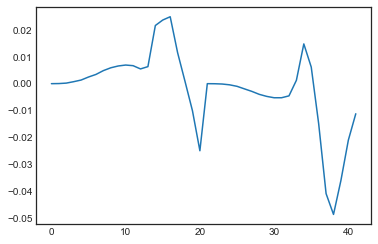

In [51]:
plt.plot(np.mean(train_targets, axis=0))
plt.show()

In [35]:
train_features = np.rollaxis(train_features, 1, 0)
train_targets = np.rollaxis(train_targets, 1, 0)

In [ ]:
def vis_features_target(features, target, feature_dics, target_dict):
    """Visualize task
    """
    
    

## Create network

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [64]:
model = Sequential([
    Dense(100, input_shape=(train_features.shape[1],)),
    Dense(100),
    Dense(train_targets.shape[1], activation='linear')
])

In [65]:
model.compile(Adam(0.001), loss='mse')

In [66]:
model.fit(train_features, train_targets, batch_size=1024, epochs=50)

Epoch 1/50
80000/80000 [==============================] - 0s - loss: 597.1450     
Epoch 2/50
80000/80000 [==============================] - 0s - loss: 6.1922     
Epoch 3/50
80000/80000 [==============================] - 0s - loss: 3.0432     
Epoch 4/50
80000/80000 [==============================] - 0s - loss: 1.9722     
Epoch 5/50
80000/80000 [==============================] - 0s - loss: 1.4039     
Epoch 6/50
80000/80000 [==============================] - 0s - loss: 1.0528     
Epoch 7/50
80000/80000 [==============================] - 0s - loss: 0.8208     
Epoch 8/50
80000/80000 [==============================] - 0s - loss: 0.6648     
Epoch 9/50
80000/80000 [==============================] - 0s - loss: 0.5554     
Epoch 10/50
80000/80000 [==============================] - 0s - loss: 0.4775     
Epoch 11/50
80000/80000 [==============================] - 0s - loss: 0.4193     
Epoch 12/50
80000/80000 [==============================] - 0s - loss: 0.3745     
Epoch 13/50
80000/80000

In [67]:
preds = model.predict(train_features)

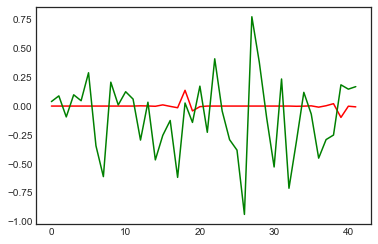

In [68]:
plt.plot(train_targets[11], c='r')
plt.plot(preds[11], c='g')
plt.show()